Original Code can be found here : https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb

### Edited and Translated to Pyton 3.11.6 By:
### Name: Marcel Zama
### Student ID: C00260146
### Date: 27/11/2023


### In Depth: Decision Trees and Random Forests
Previously we have looked in depth at a simple generative classifier (naive Bayes; see In Depth: Naive Bayes Classification) and a powerful discriminative classifier (support vector machines; see In-Depth: Support Vector Machines). Here we'll take a look at another powerful algorithm: a nonparametric algorithm called random forests. Random forests are an example of an ensemble method, meaning one that relies on aggregating the results of a set of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, the predictive accuracy of a majority vote among a number of estimators can end up being better than that of any of the individual estimators doing the voting! We will see examples of this in the following sections.

We begin with the standard imports:

In [28]:
# Import necessary library
import matplotlib.pyplot as plt

# Display available Matplotlib plot styles
print(plt.style.available)  # Print the list of available styles

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [29]:
# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Set the plot style to 'seaborn-v0_8-whitegrid'
plt.style.use('seaborn-v0_8-whitegrid')

# Now you can create and display your plots using Matplotlib
# For example, you can use the plt.scatter function to create a scatter plot
# or other plotting functions as needed for your data visualization.

### Motivating Random Forests: Decision Trees
Random forests are an example of an ensemble learner built on decision trees. For this reason, we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification. For example, if you wanted to build a decision tree to classify animals you come across while on a hike, you might construct the one shown in the following figure.

 figure source in Appendix

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. Let's now look at an example of this.

In [30]:
# Install scikit-learn library using pip
# If you're running this code in a Jupyter Notebook, use !pip
# If you're running it in a script or terminal, use pip directly

!pip install scikit-learn

# Creating a Decision Tree
Consider the following two-dimensional data, which has one of four class labels (see the following figure):

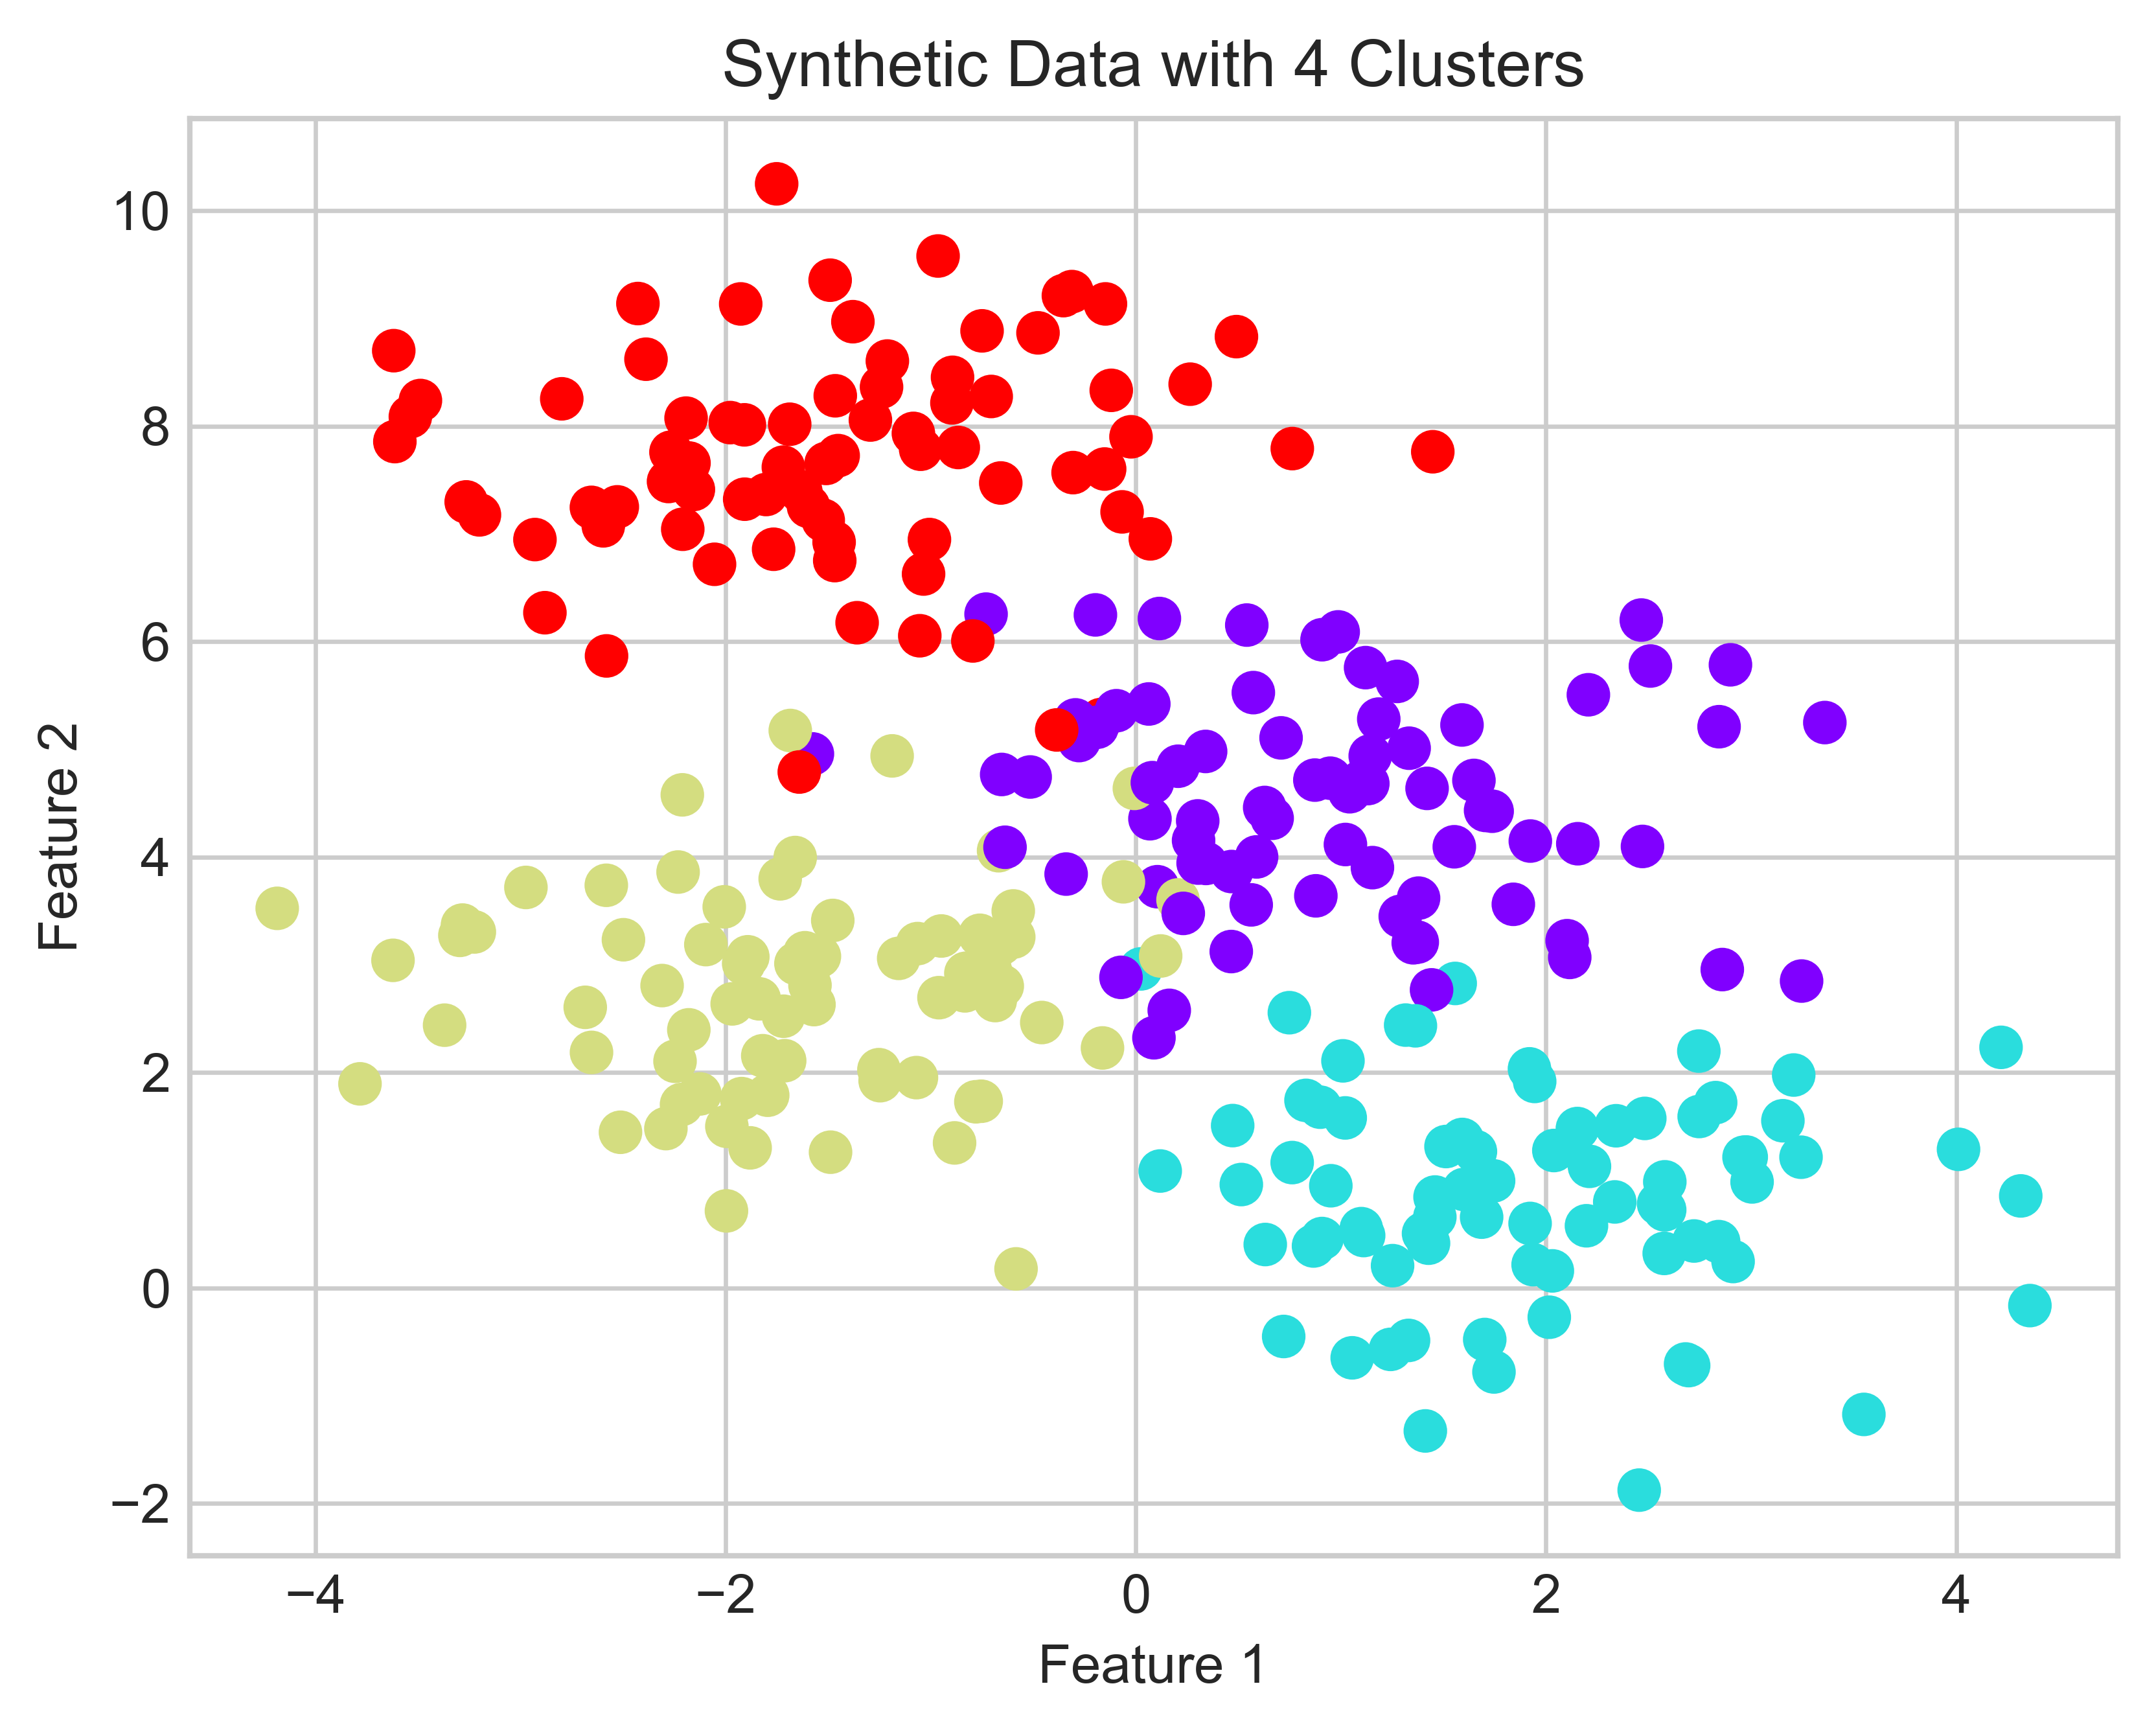

In [31]:
# Import necessary libraries
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data with 4 clusters using make_blobs
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)

# Plot the generated data using matplotlib
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

# Customize the plot
plt.title('Synthetic Data with 4 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

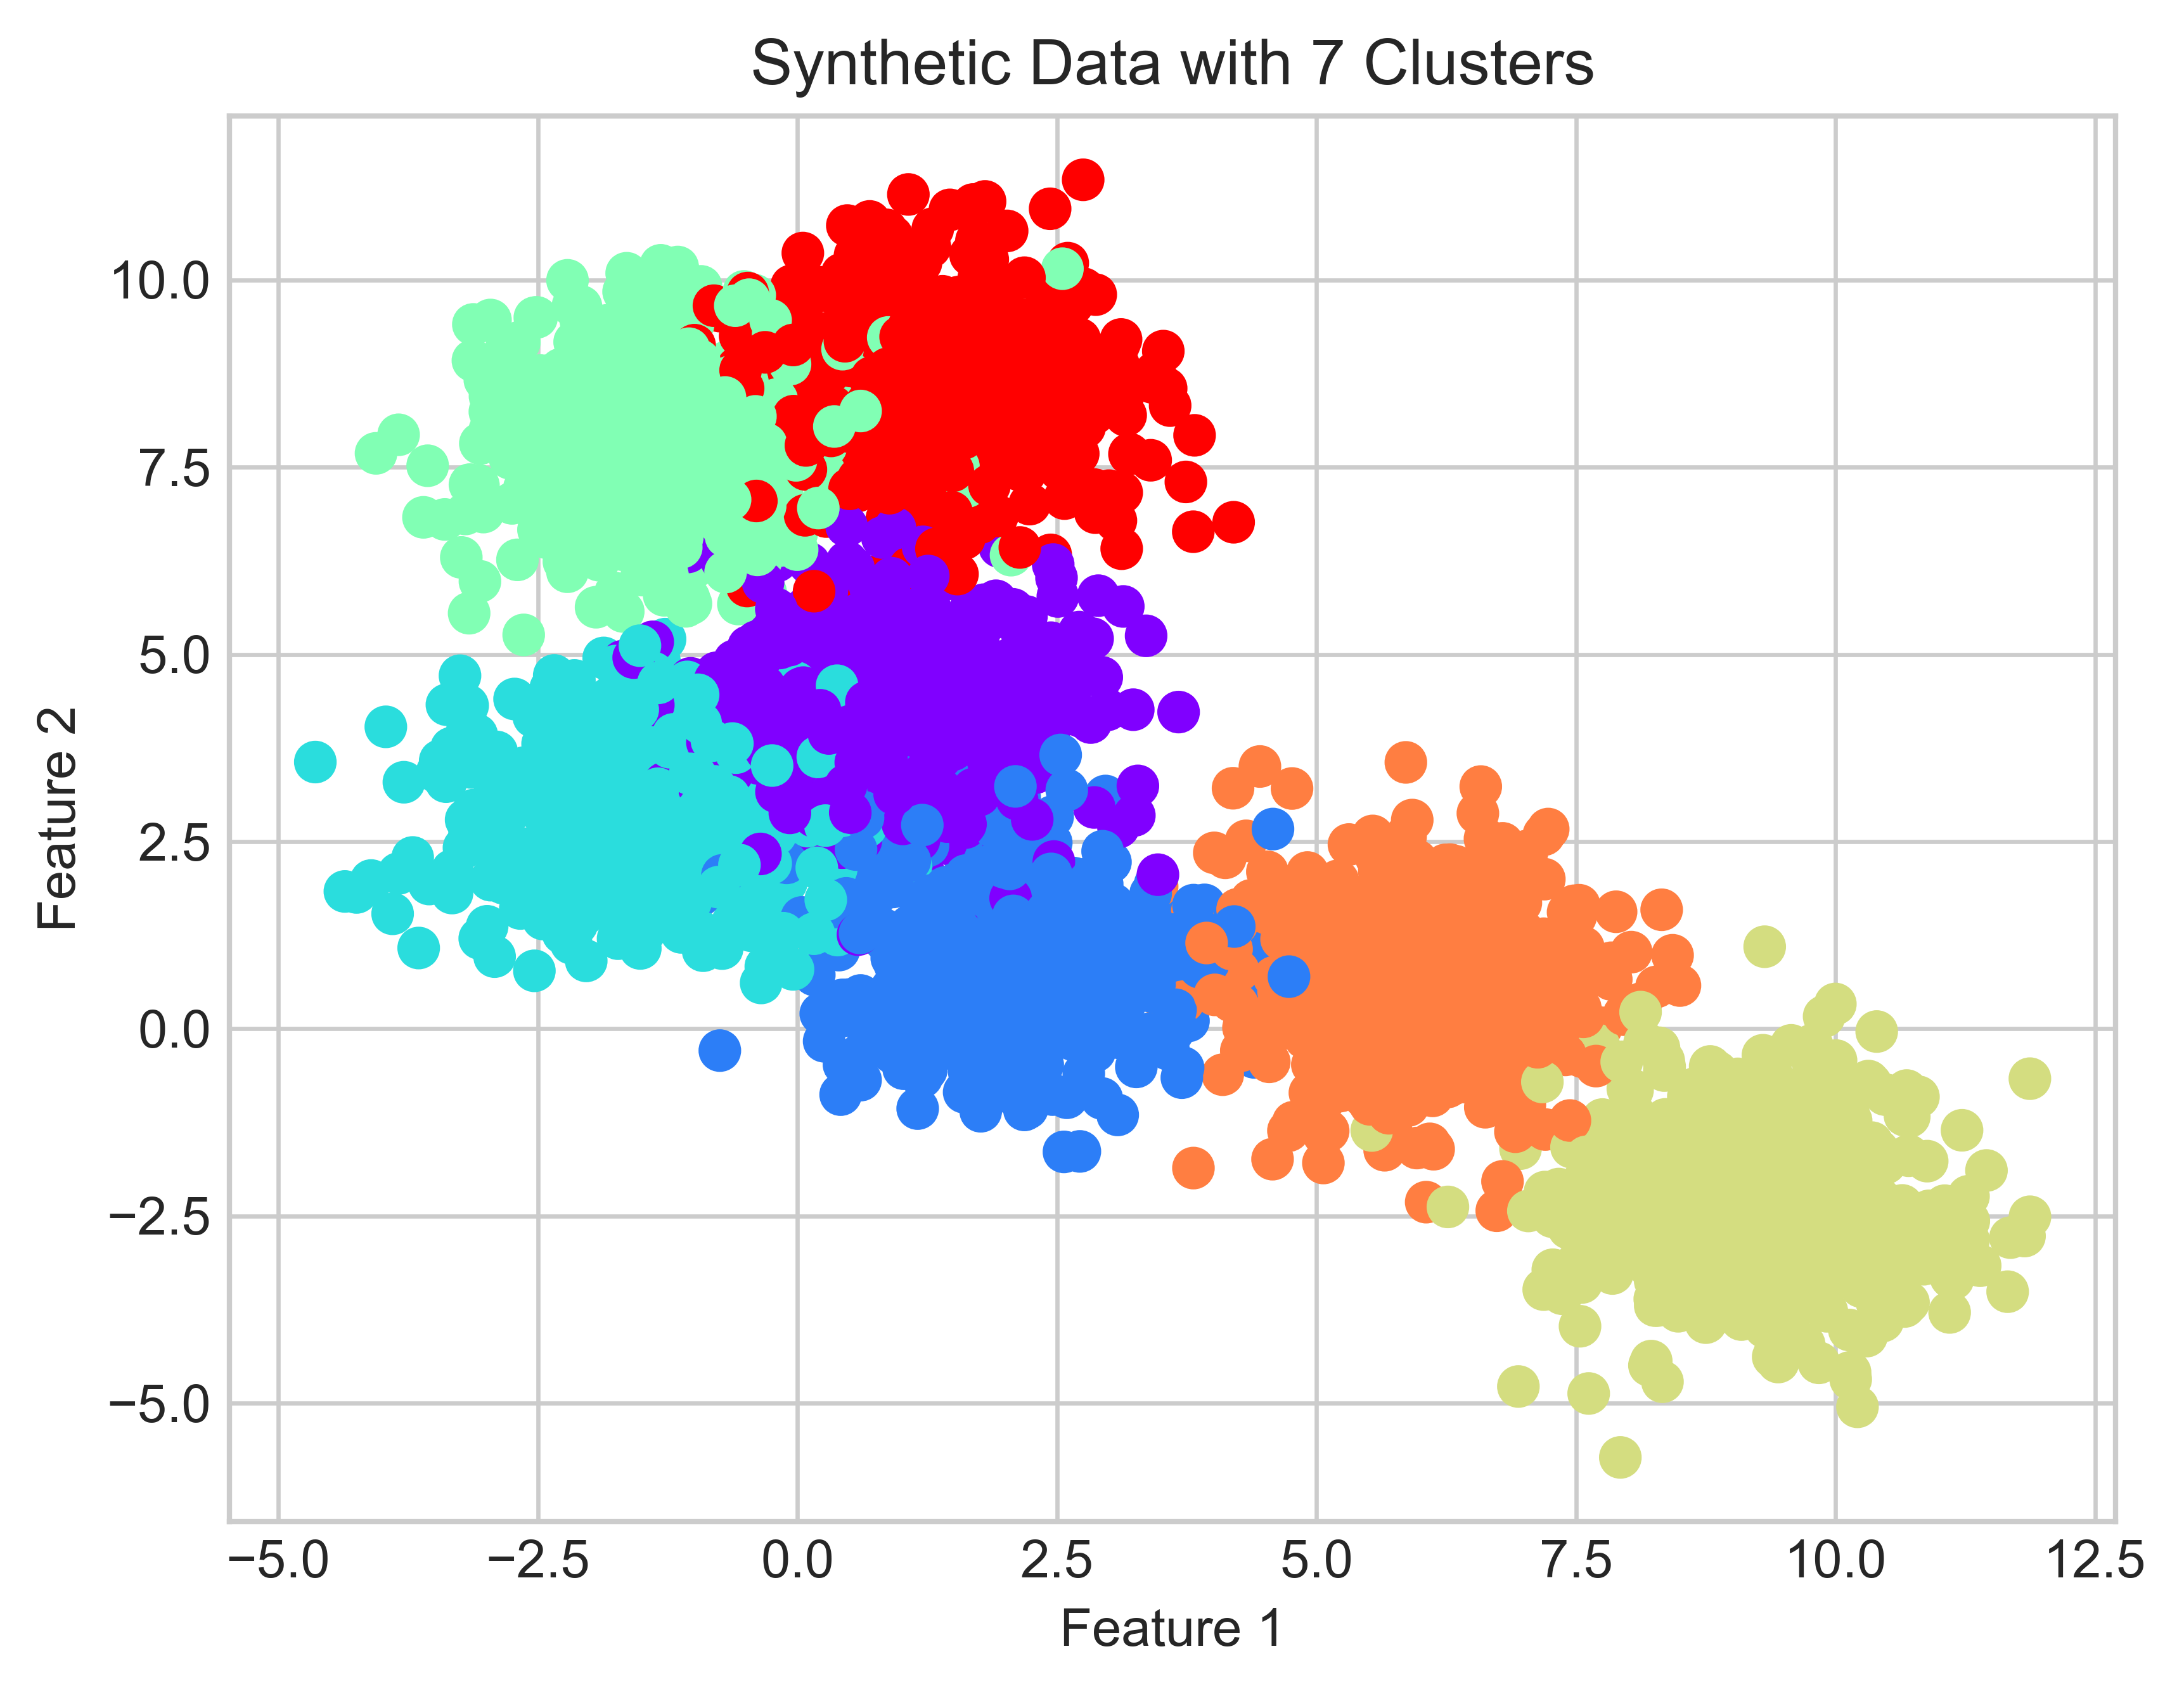

In [32]:
# Import necessary libraries
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data with 7 clusters using make_blobs
X, y = make_blobs(n_samples=3000, centers=7, random_state=0, cluster_std=1.0)

# Plot the generated data using matplotlib
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

# Customize the plot
plt.title('Synthetic Data with 7 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. The following figure presents a visualization of the first four levels of a decision tree classifier for this data.

 [figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. Except for nodes that contain all of one color, at each level every region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the DecisionTreeClassifier estimator:

In [33]:
# Import necessary library
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier and fit it to the data
tree = DecisionTreeClassifier().fit(X, y)

Let's write a utility function to help us visualize the output of the classifier:

In [34]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    # If an axis is not provided, use the current axis
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    
    # Adjust axis settings
    ax.axis('tight')
    ax.axis('off')
    
    # Get current axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Fit the estimator (model) to the training data
    model.fit(X, y)
    
    # Create a meshgrid for visualization
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    
    # Predict labels for each point in the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results (decision boundaries)
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    # Set the axis limits based on the original limits
    ax.set(xlim=xlim, ylim=ylim)


Now we can examine what the decision tree classification looks like (see the following figure):

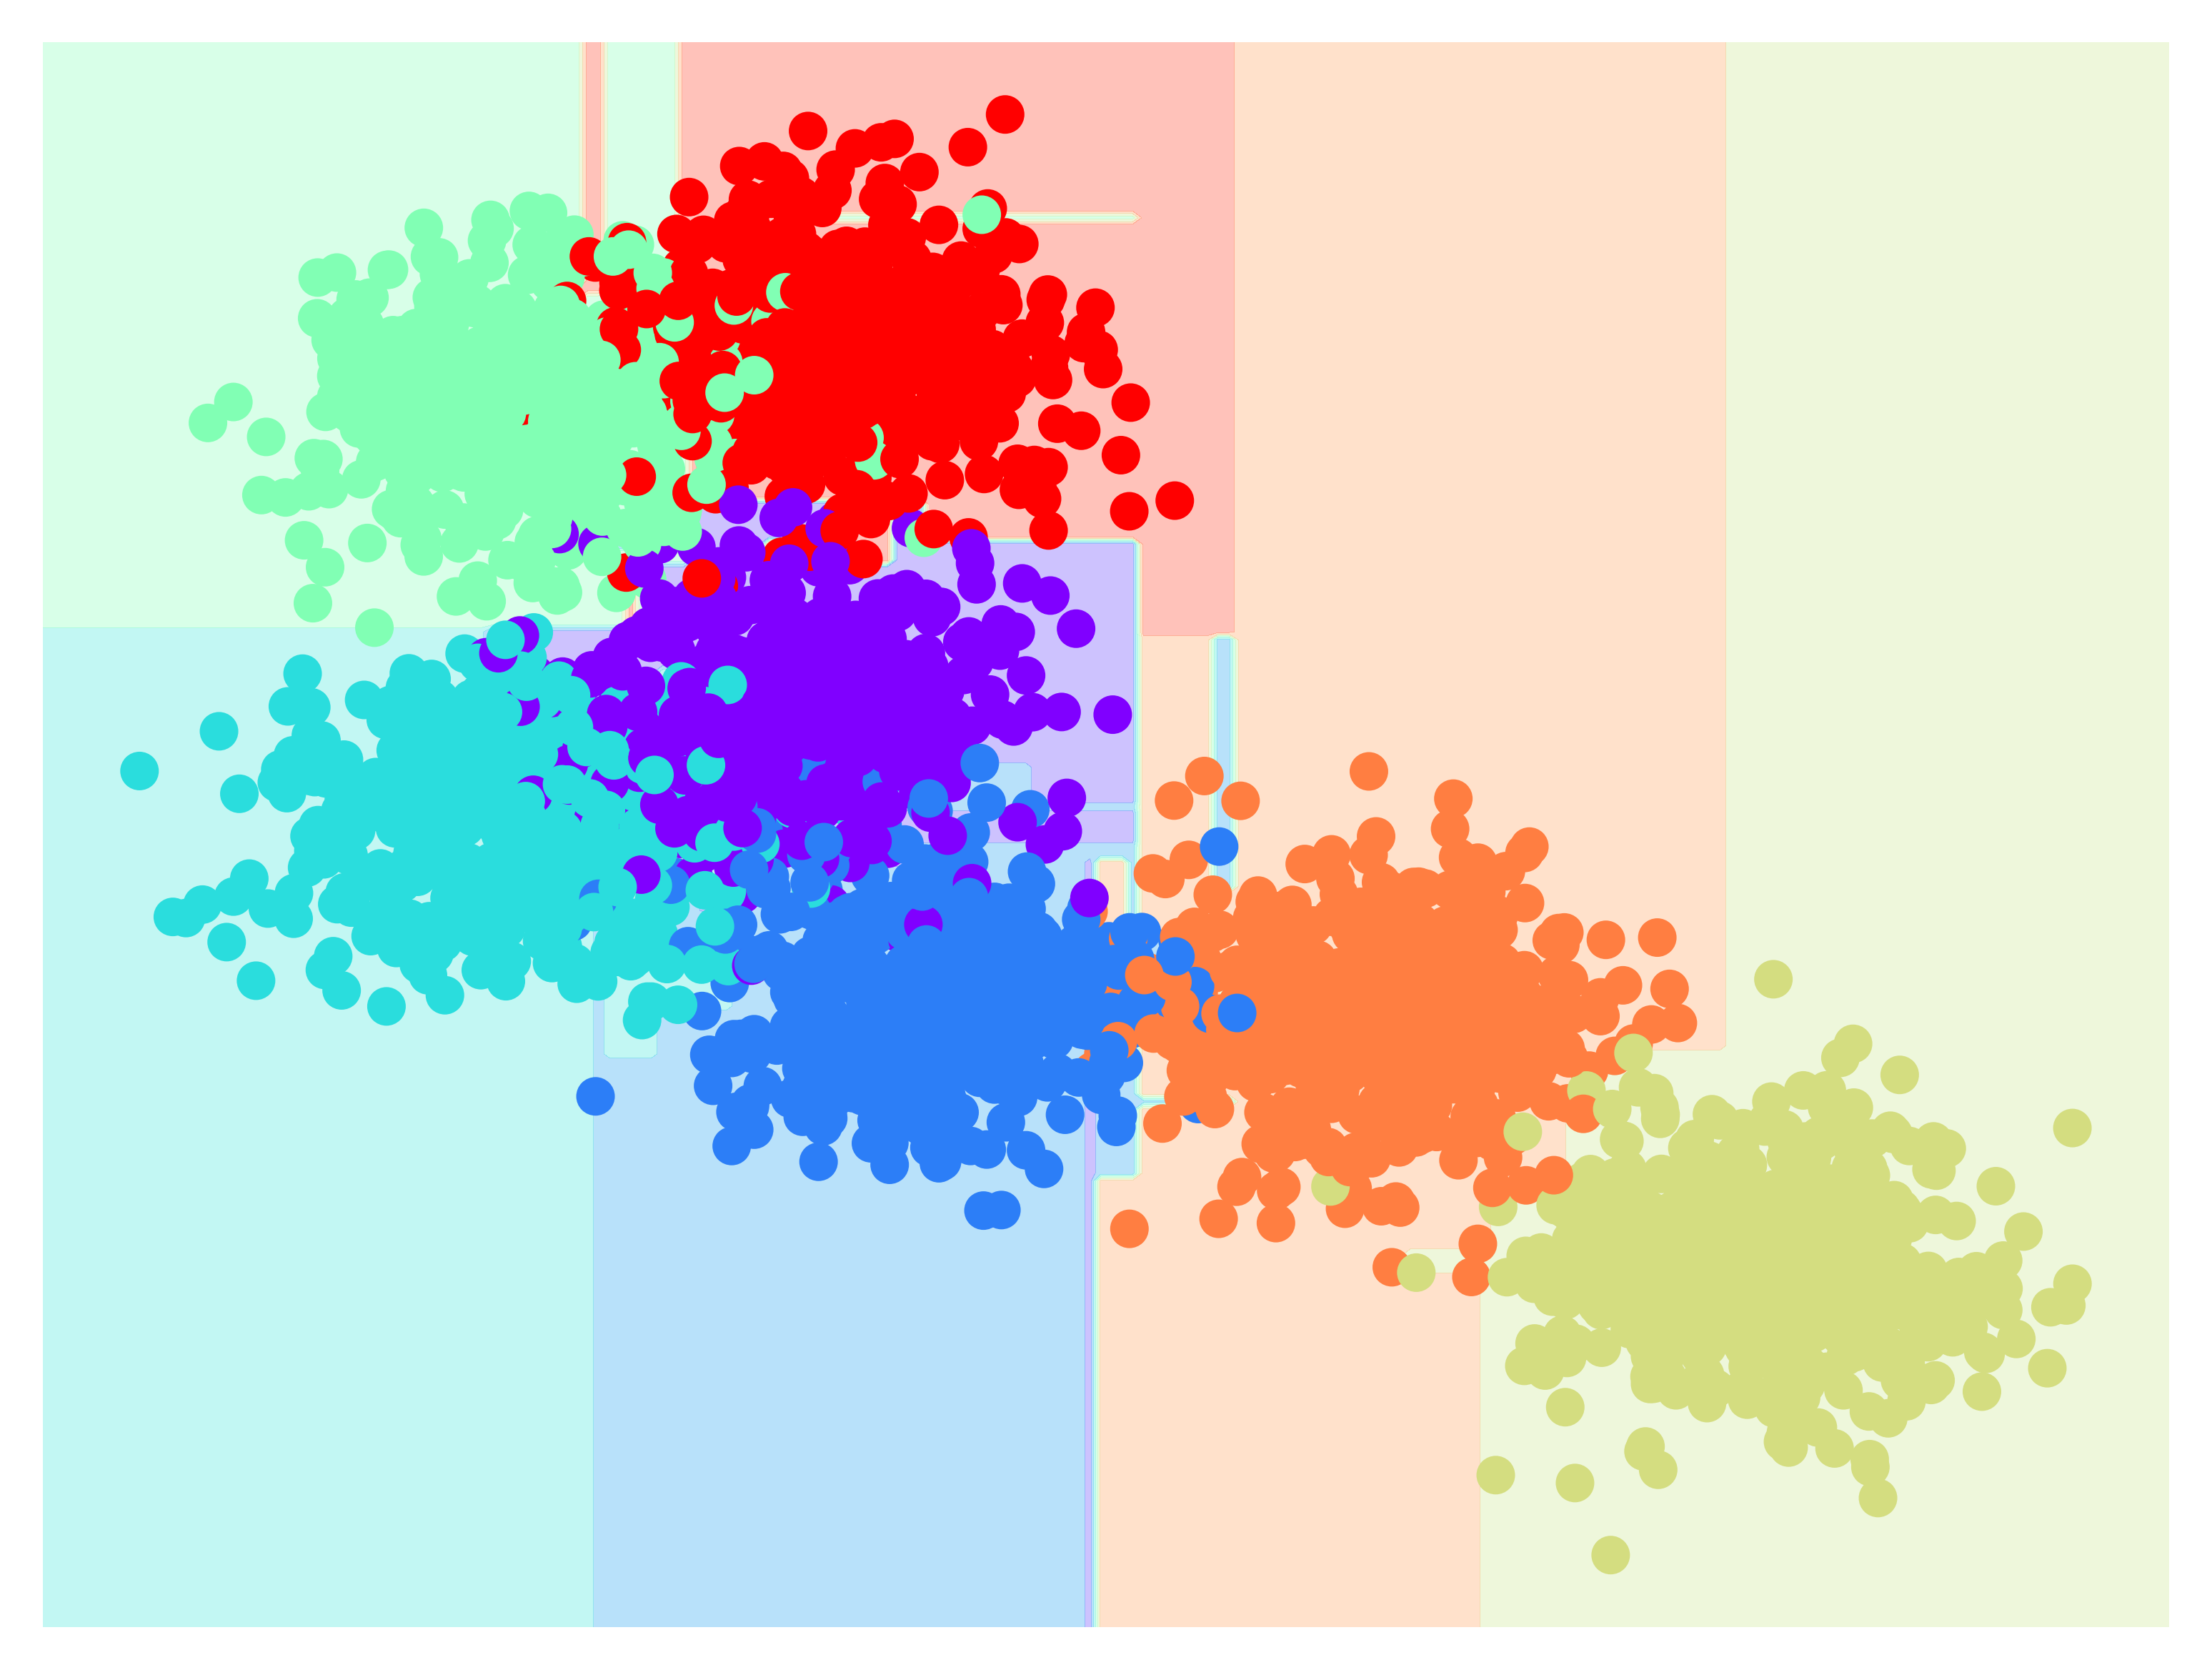

In [35]:
# Call the visualize_classifier function with the DecisionTreeClassifier model, input data X, and labels y
visualize_classifier(DecisionTreeClassifier(), X, y)

If you're running this notebook live, you can use the helper script included in the online appendix to bring up an interactive visualization of the decision tree building process:

In [36]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y)

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

<function helpers_05_08.plot_tree_interactive.<locals>.interactive_tree(depth=5)>

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…
<function helpers_05_08.plot_tree_interactive.<locals>.interactive_tree(depth=5)>
Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions. It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly overfitting our data.

### Decision Trees and Overfitting

Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions it is drawn from. Another way to see this overfitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data.

(figure source in Appendix)[https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting]

It is clear that in some places the two trees produce consistent results (e.g., in the four corners), while in other places the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

In [37]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
# Call the randomized_tree_interactive function with the input data X and labels y
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…
Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

# Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called bagging. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a random forest.

This type of bagging classification can be done manually using Scikit-Learn's BaggingClassifier meta-estimator, as shown here (see the following figure):

C:\Users\Ben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Ben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


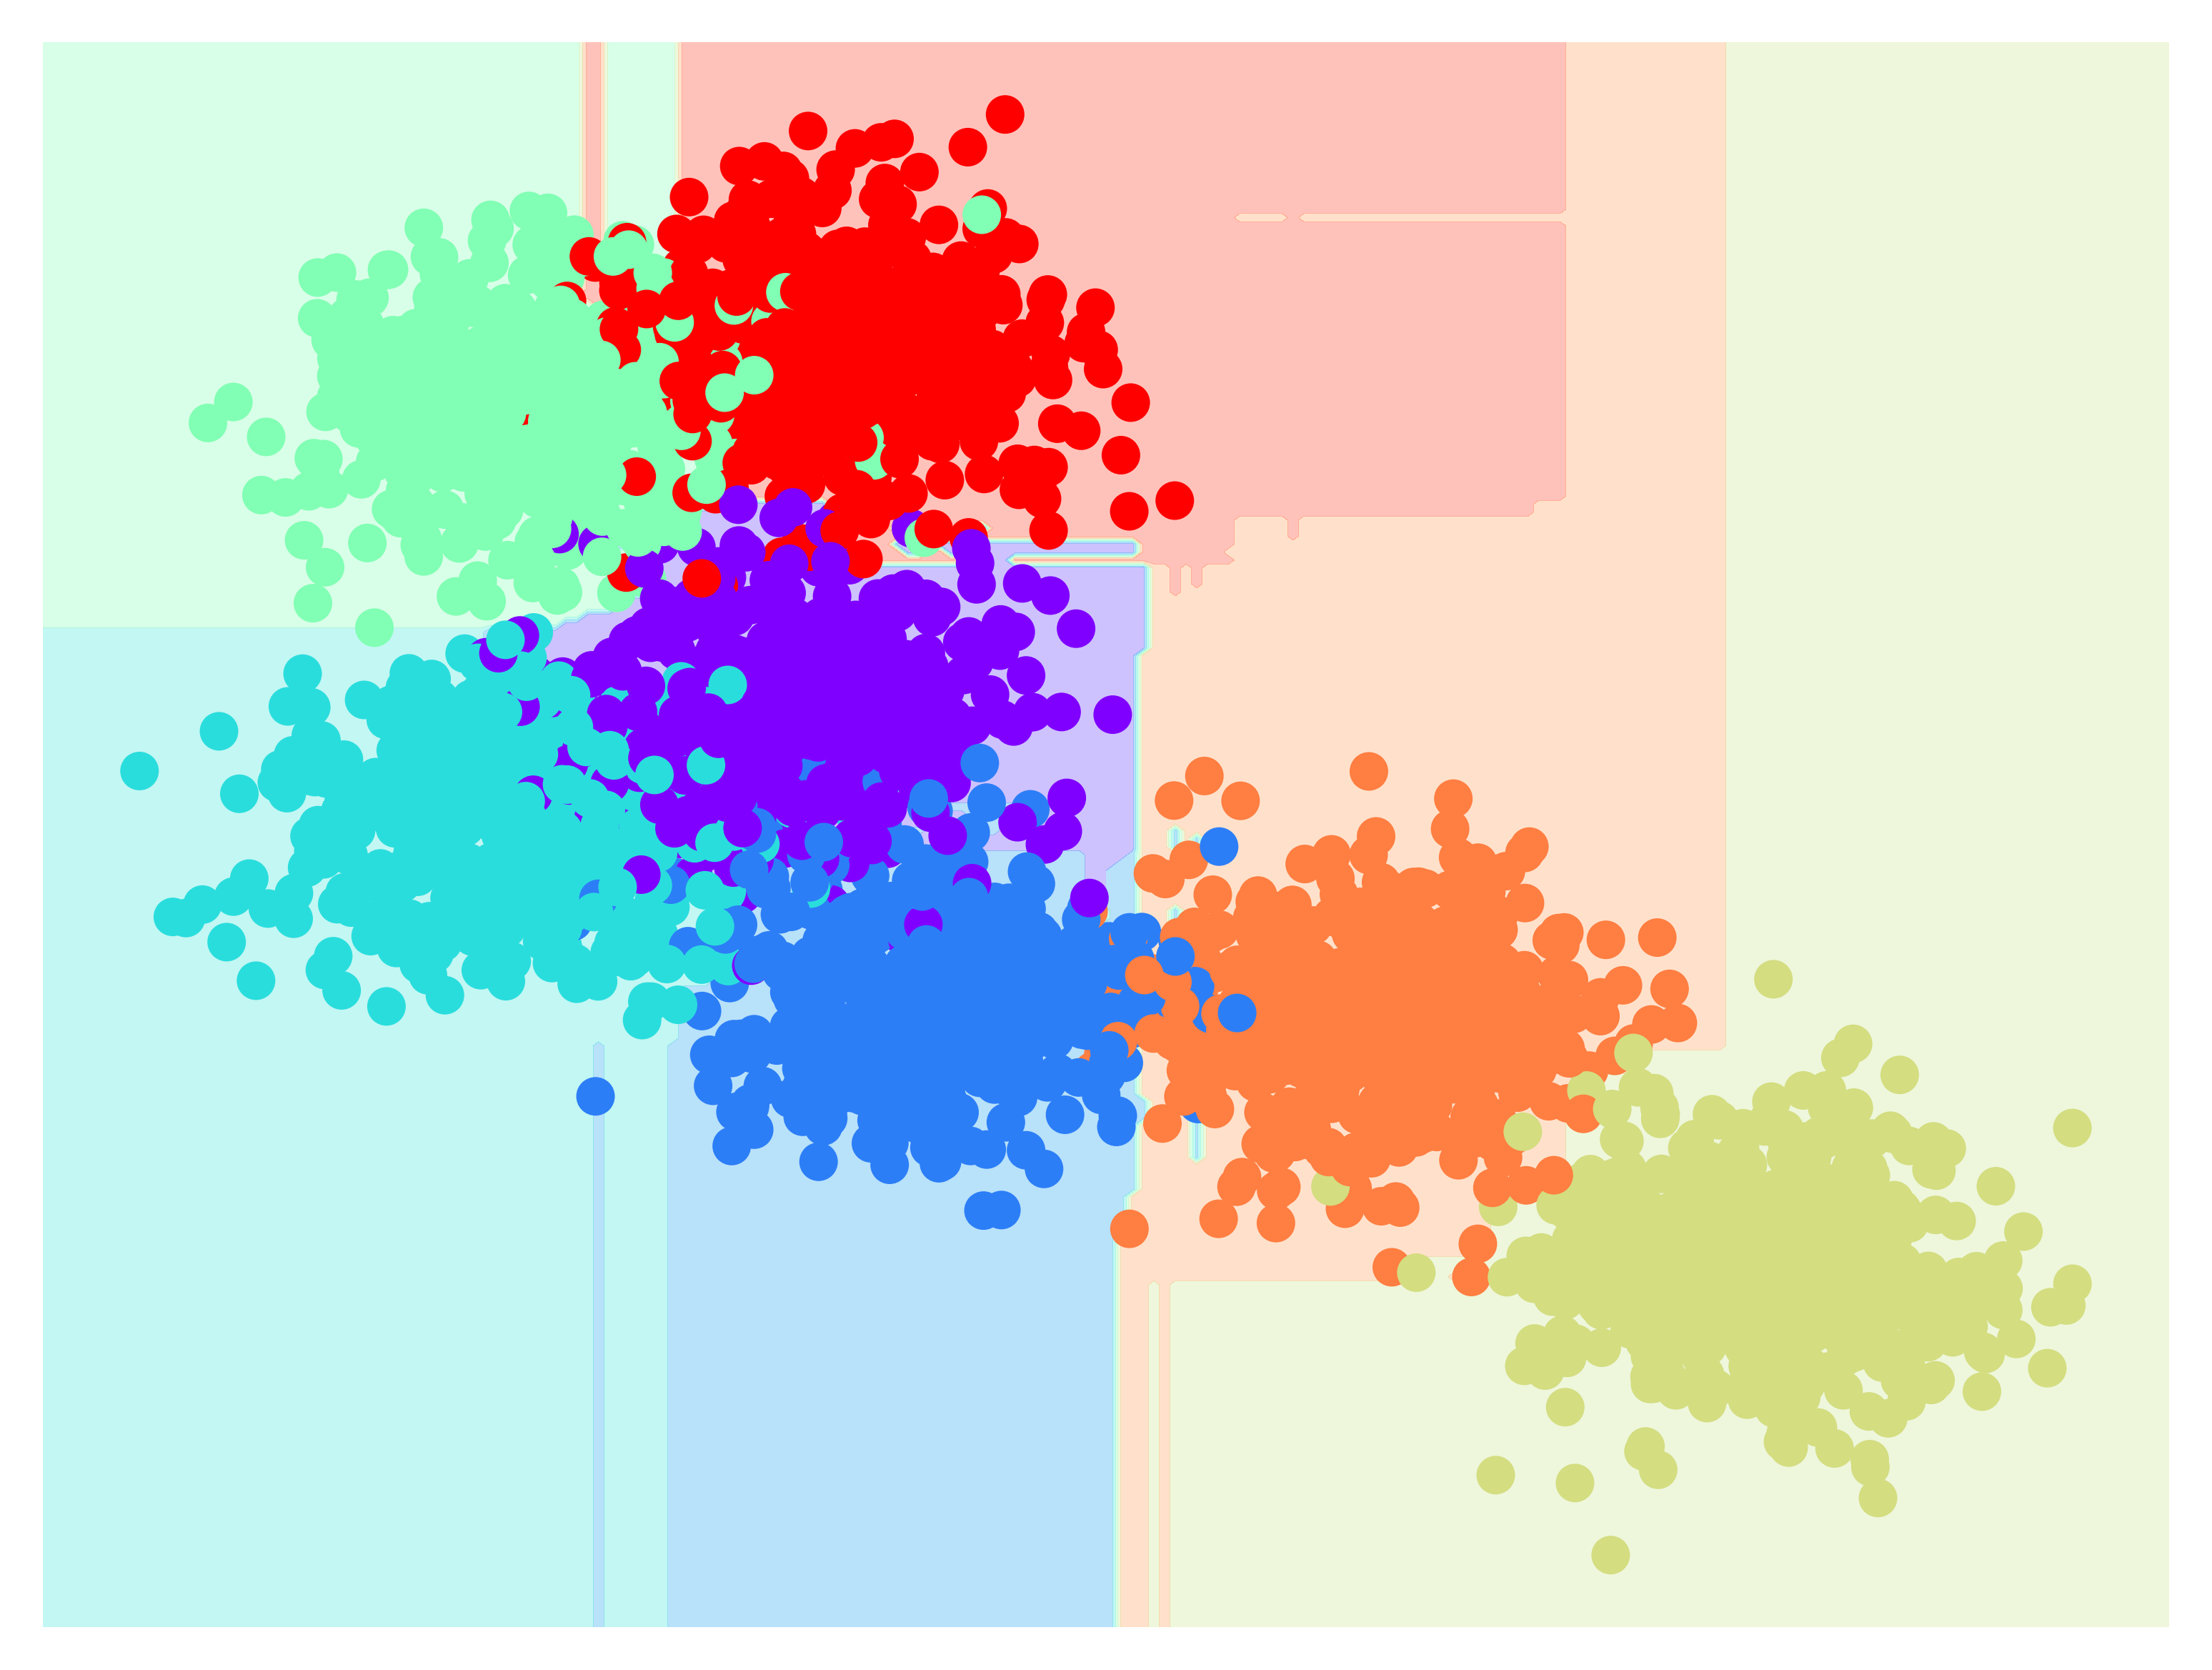

In [38]:
# Import necessary modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Create a Decision Tree Classifier
tree = DecisionTreeClassifier()

# Create a Bagging Classifier with 100 base estimators, using 80% of samples for each estimator
bag = BaggingClassifier(base_estimator=tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

# Fit the Bagging Classifier on the data (assuming X, y are defined earlier)
bag.fit(X, y)

# Visualize the Bagging Classifier
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the (Scikit-Learn documentation)[https://scikit-learn.org/stable/modules/ensemble.html#forest] and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly—in parallel, if desired—fit the ensemble of trees (see the following figure):

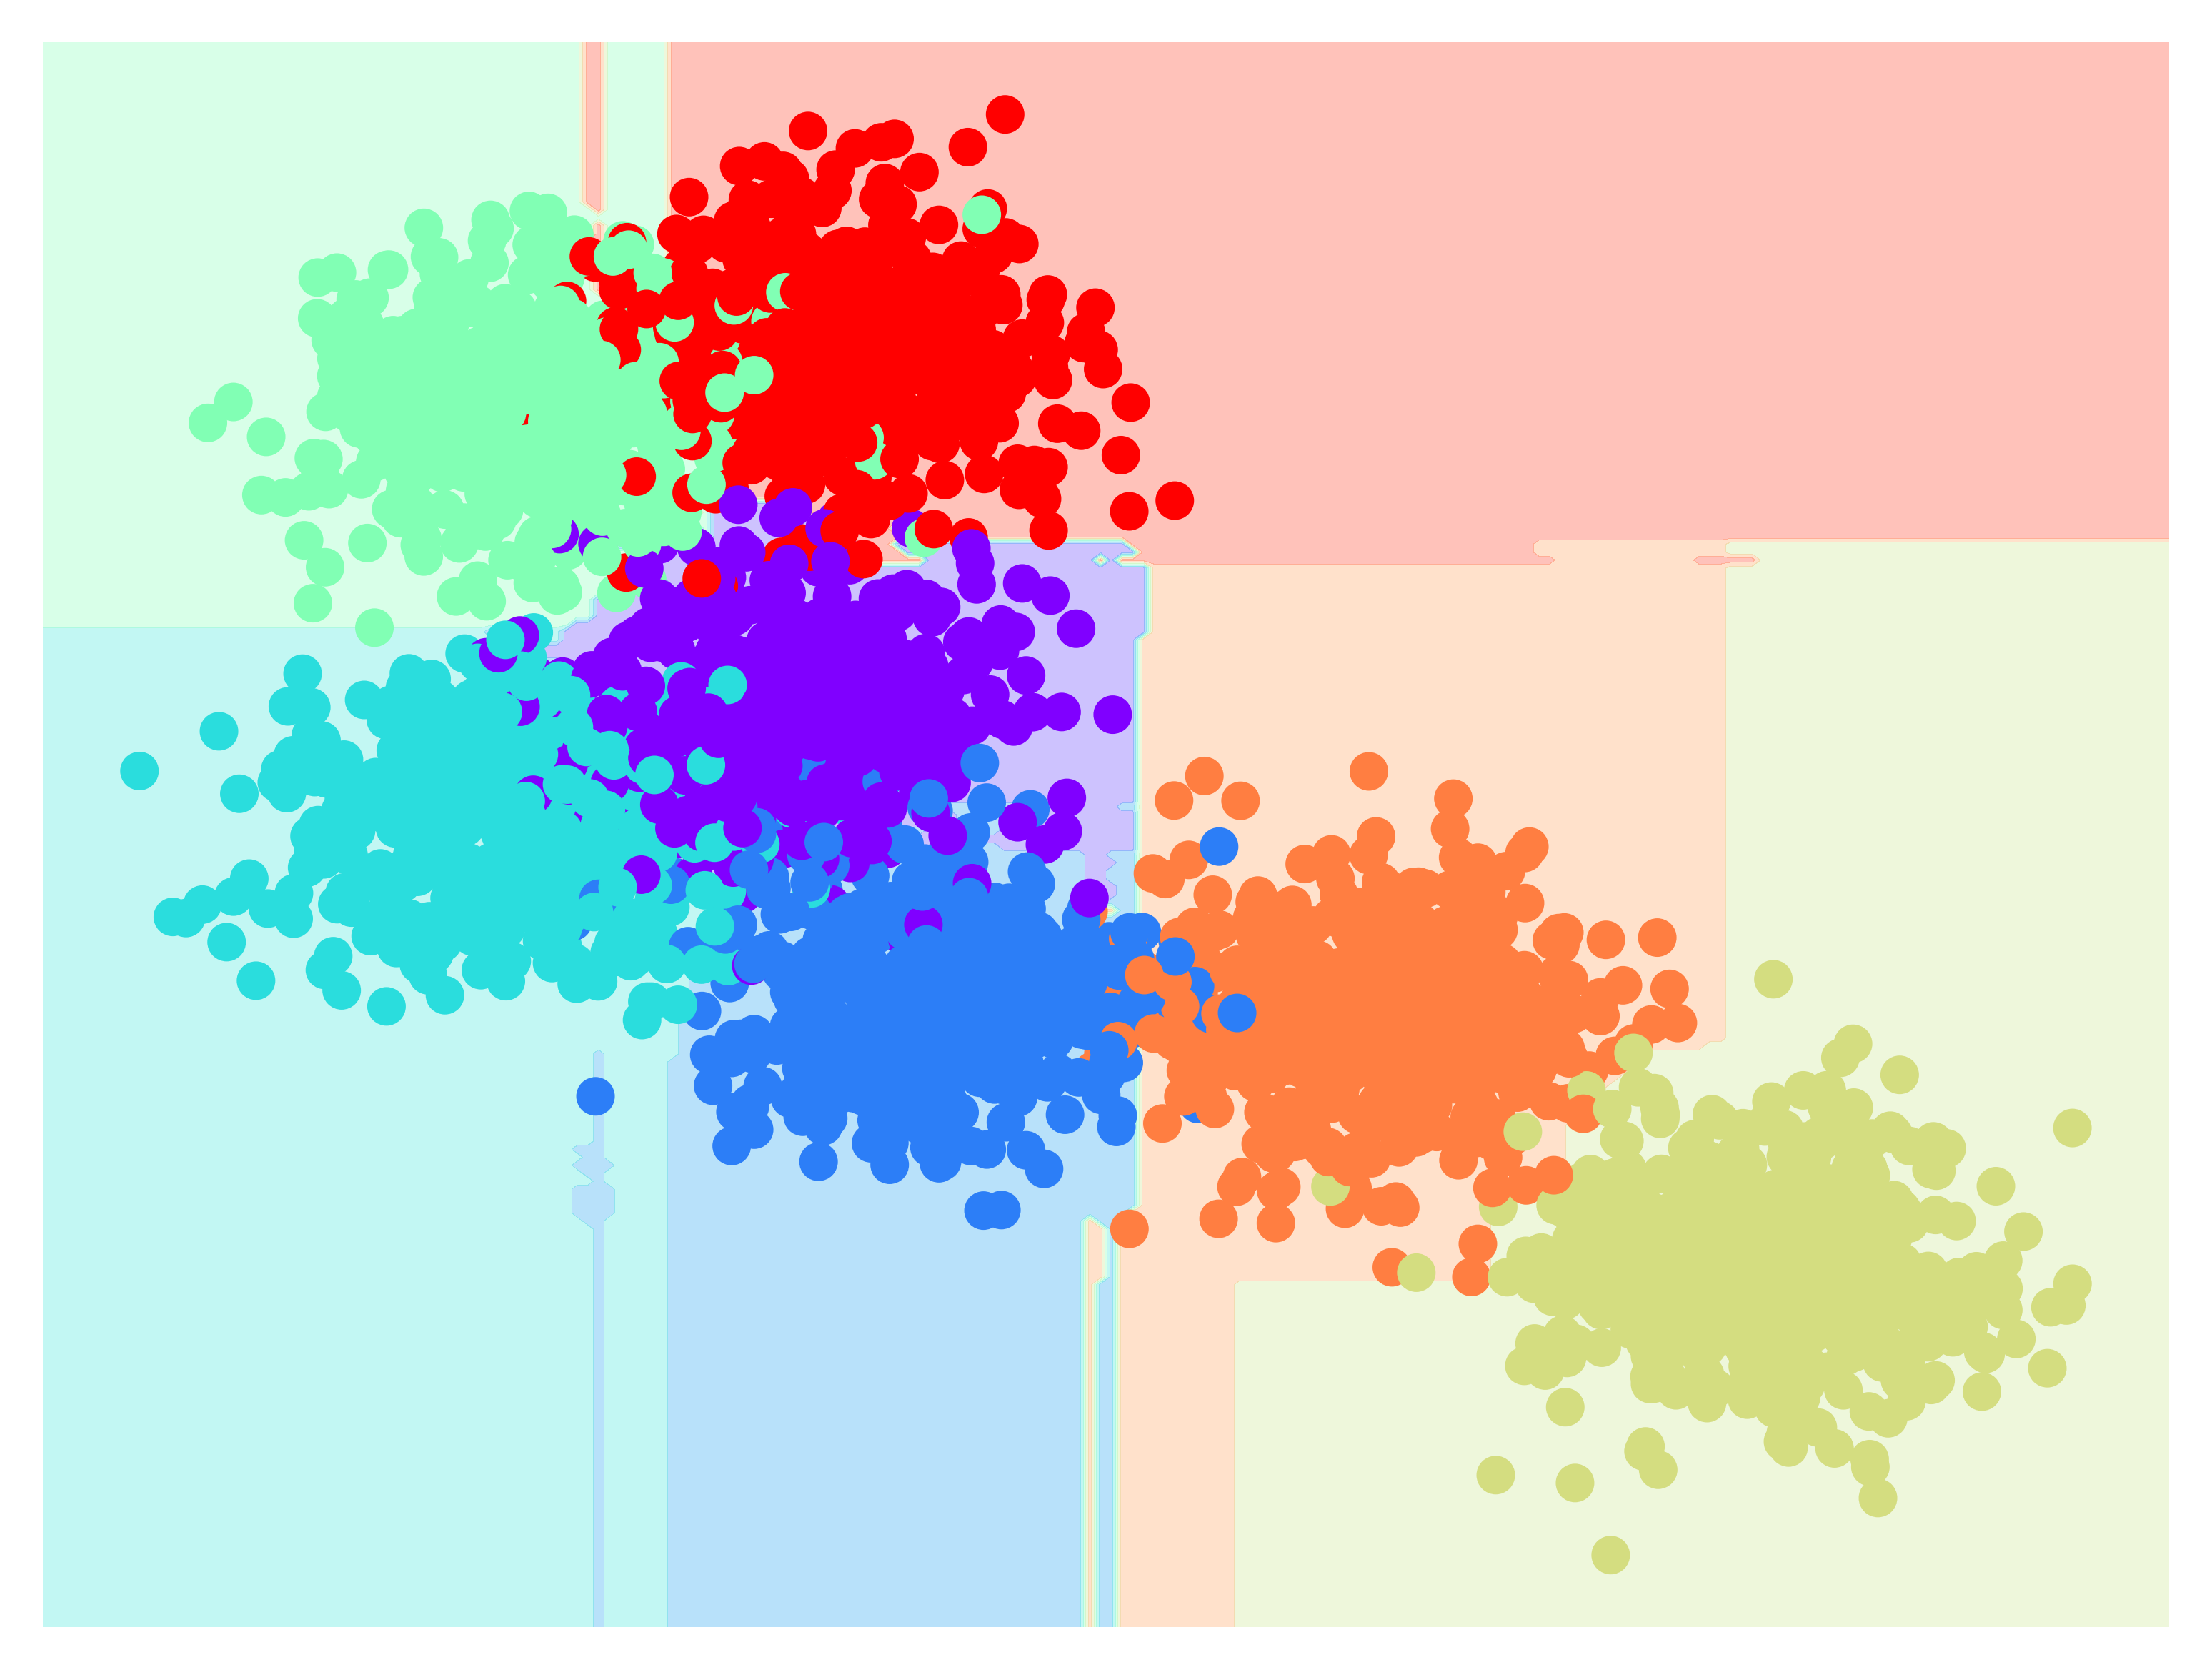

In [39]:
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier with 100 trees
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Visualize the RandomForestClassifier
visualize_classifier(model, X, y)

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

# Random Forest Regression

In the previous section we considered random forests within the context of classification. Random forests can also be made to work in the case of regression (that is, with continuous rather than categorical variables). The estimator to use for this is the RandomForestRegressor, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation (see the following figure):

<ErrorbarContainer object of 3 artists>

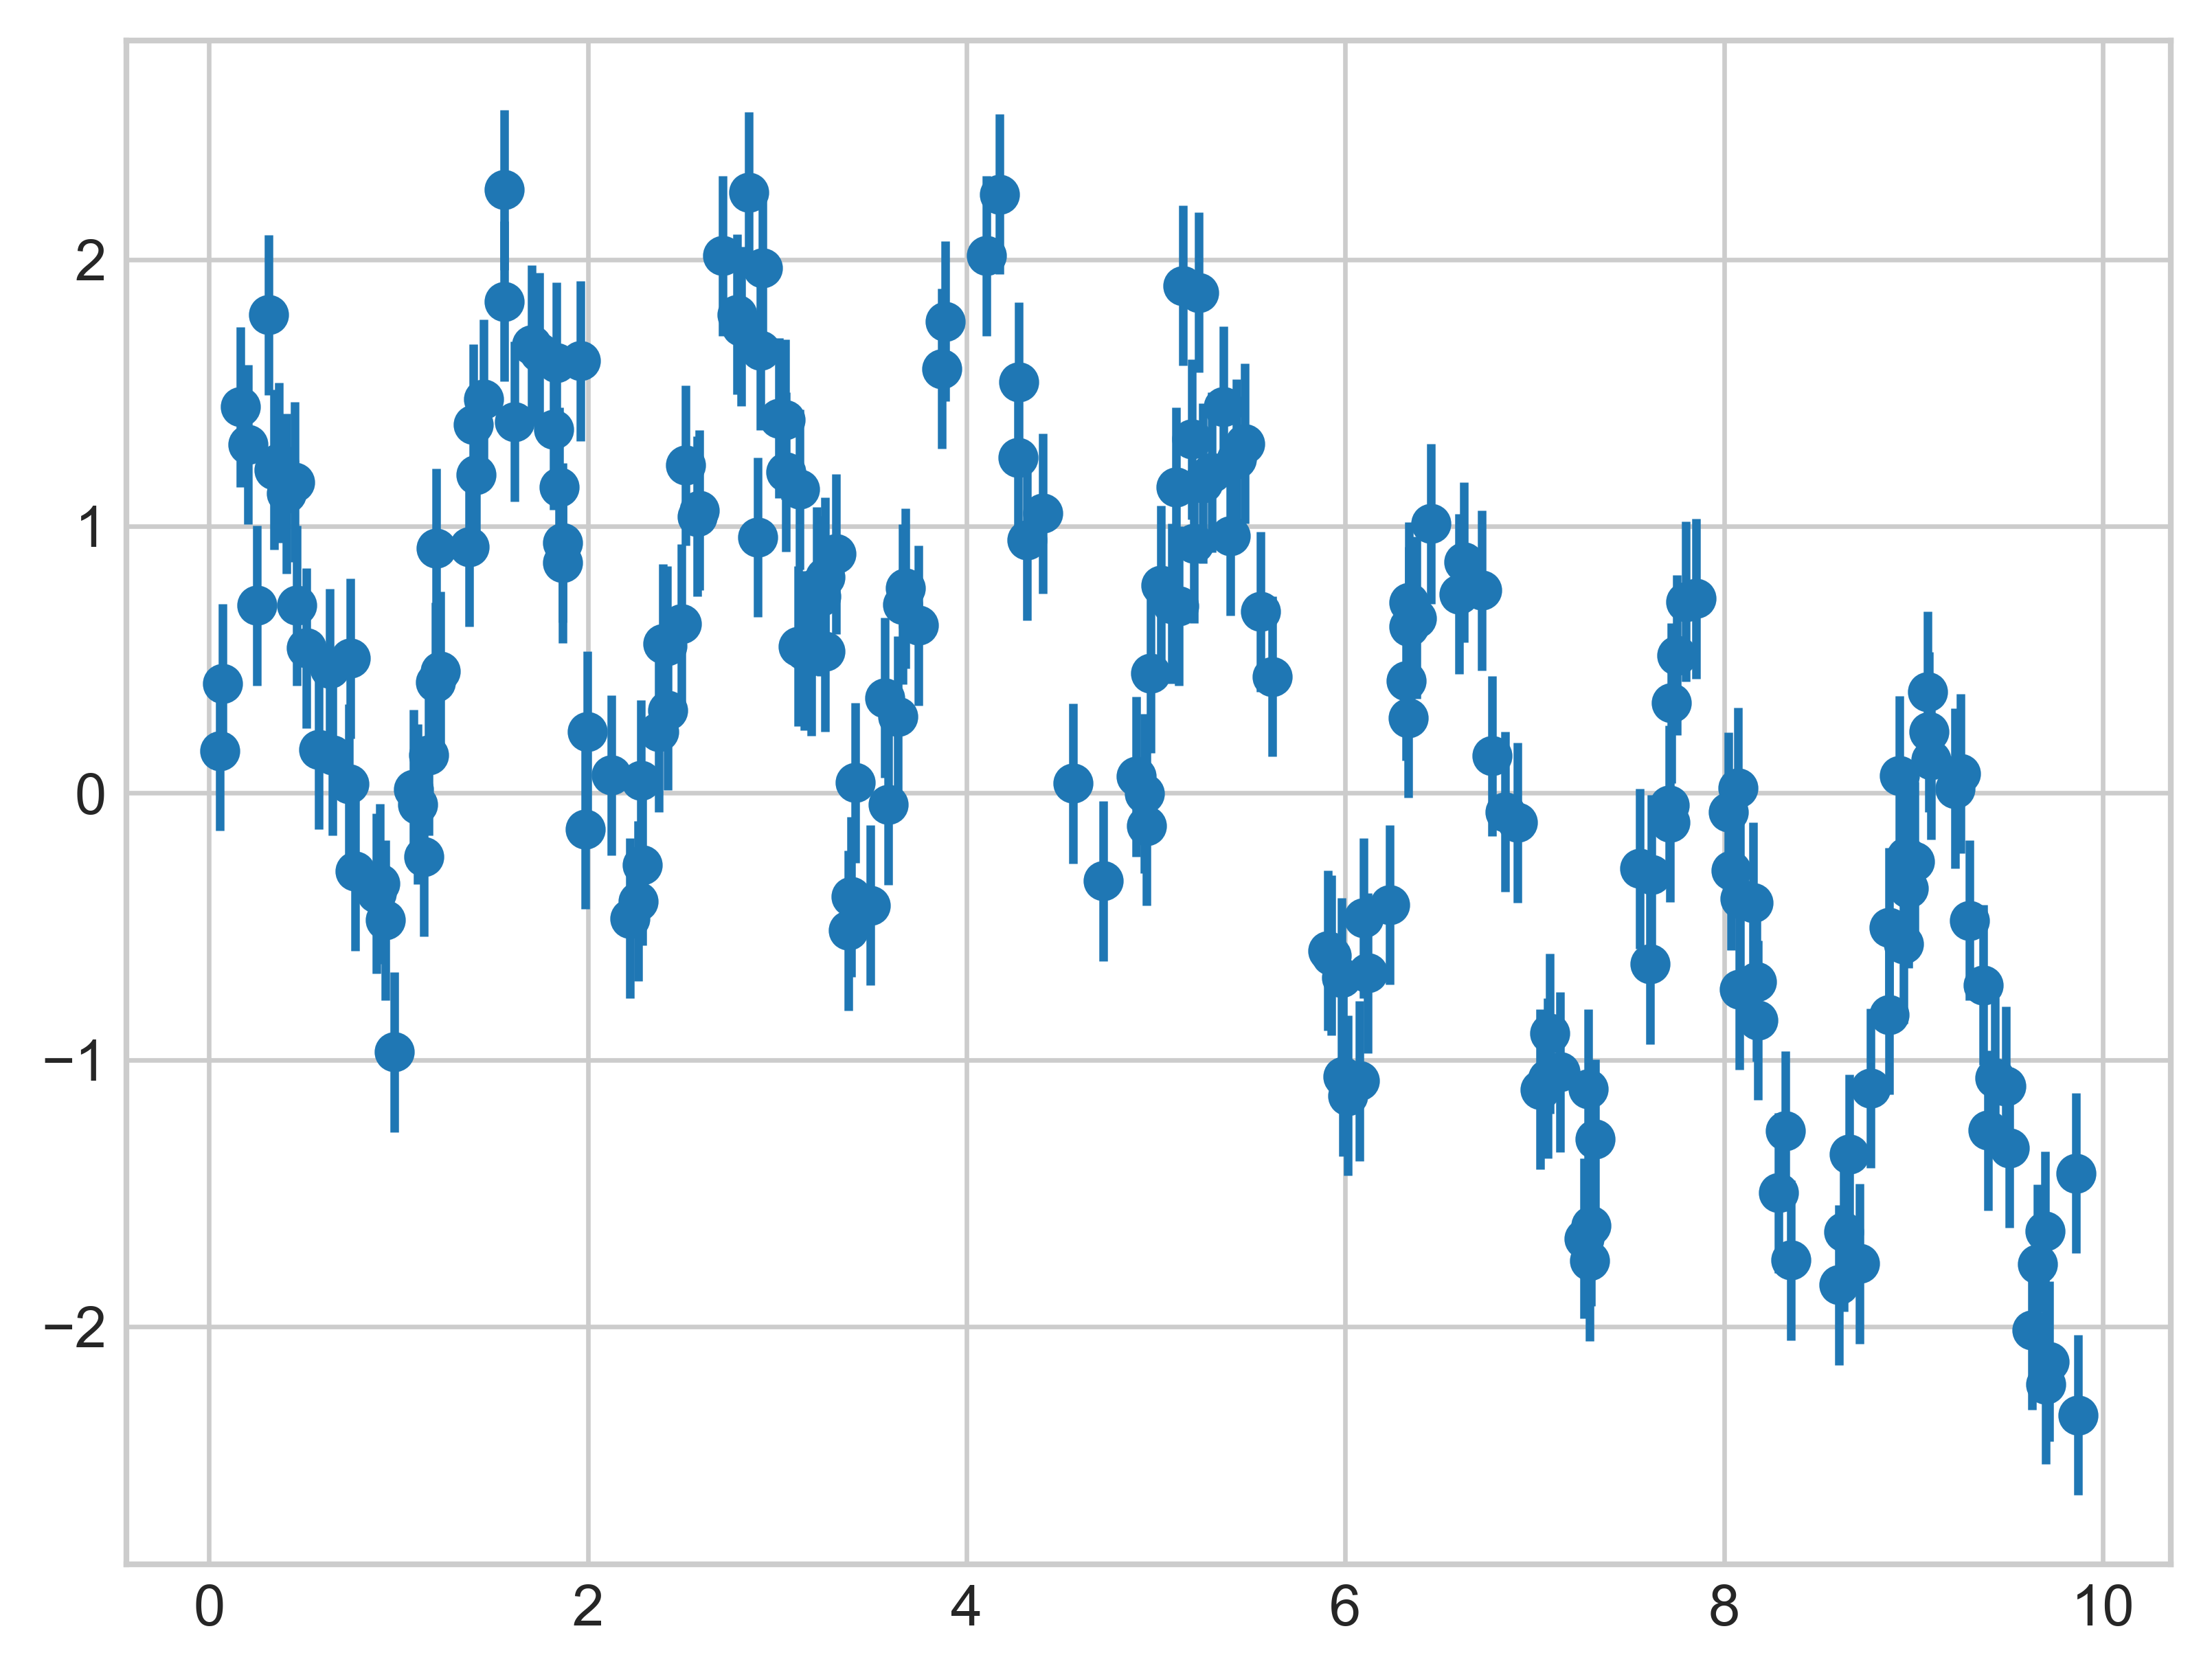

In [40]:
# Set random seed for reproducibility
rng = np.random.RandomState(42)

# Generate random data
x = 10 * rng.rand(200)

# Define a model function with oscillations and noise
def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

# Generate y values using the model
y = model(x)

# Plot the data points with error bars
plt.errorbar(x, y, 0.3, fmt='o')

Using the random forest regressor, we can find the best-fit curve as follows (see the following figure):

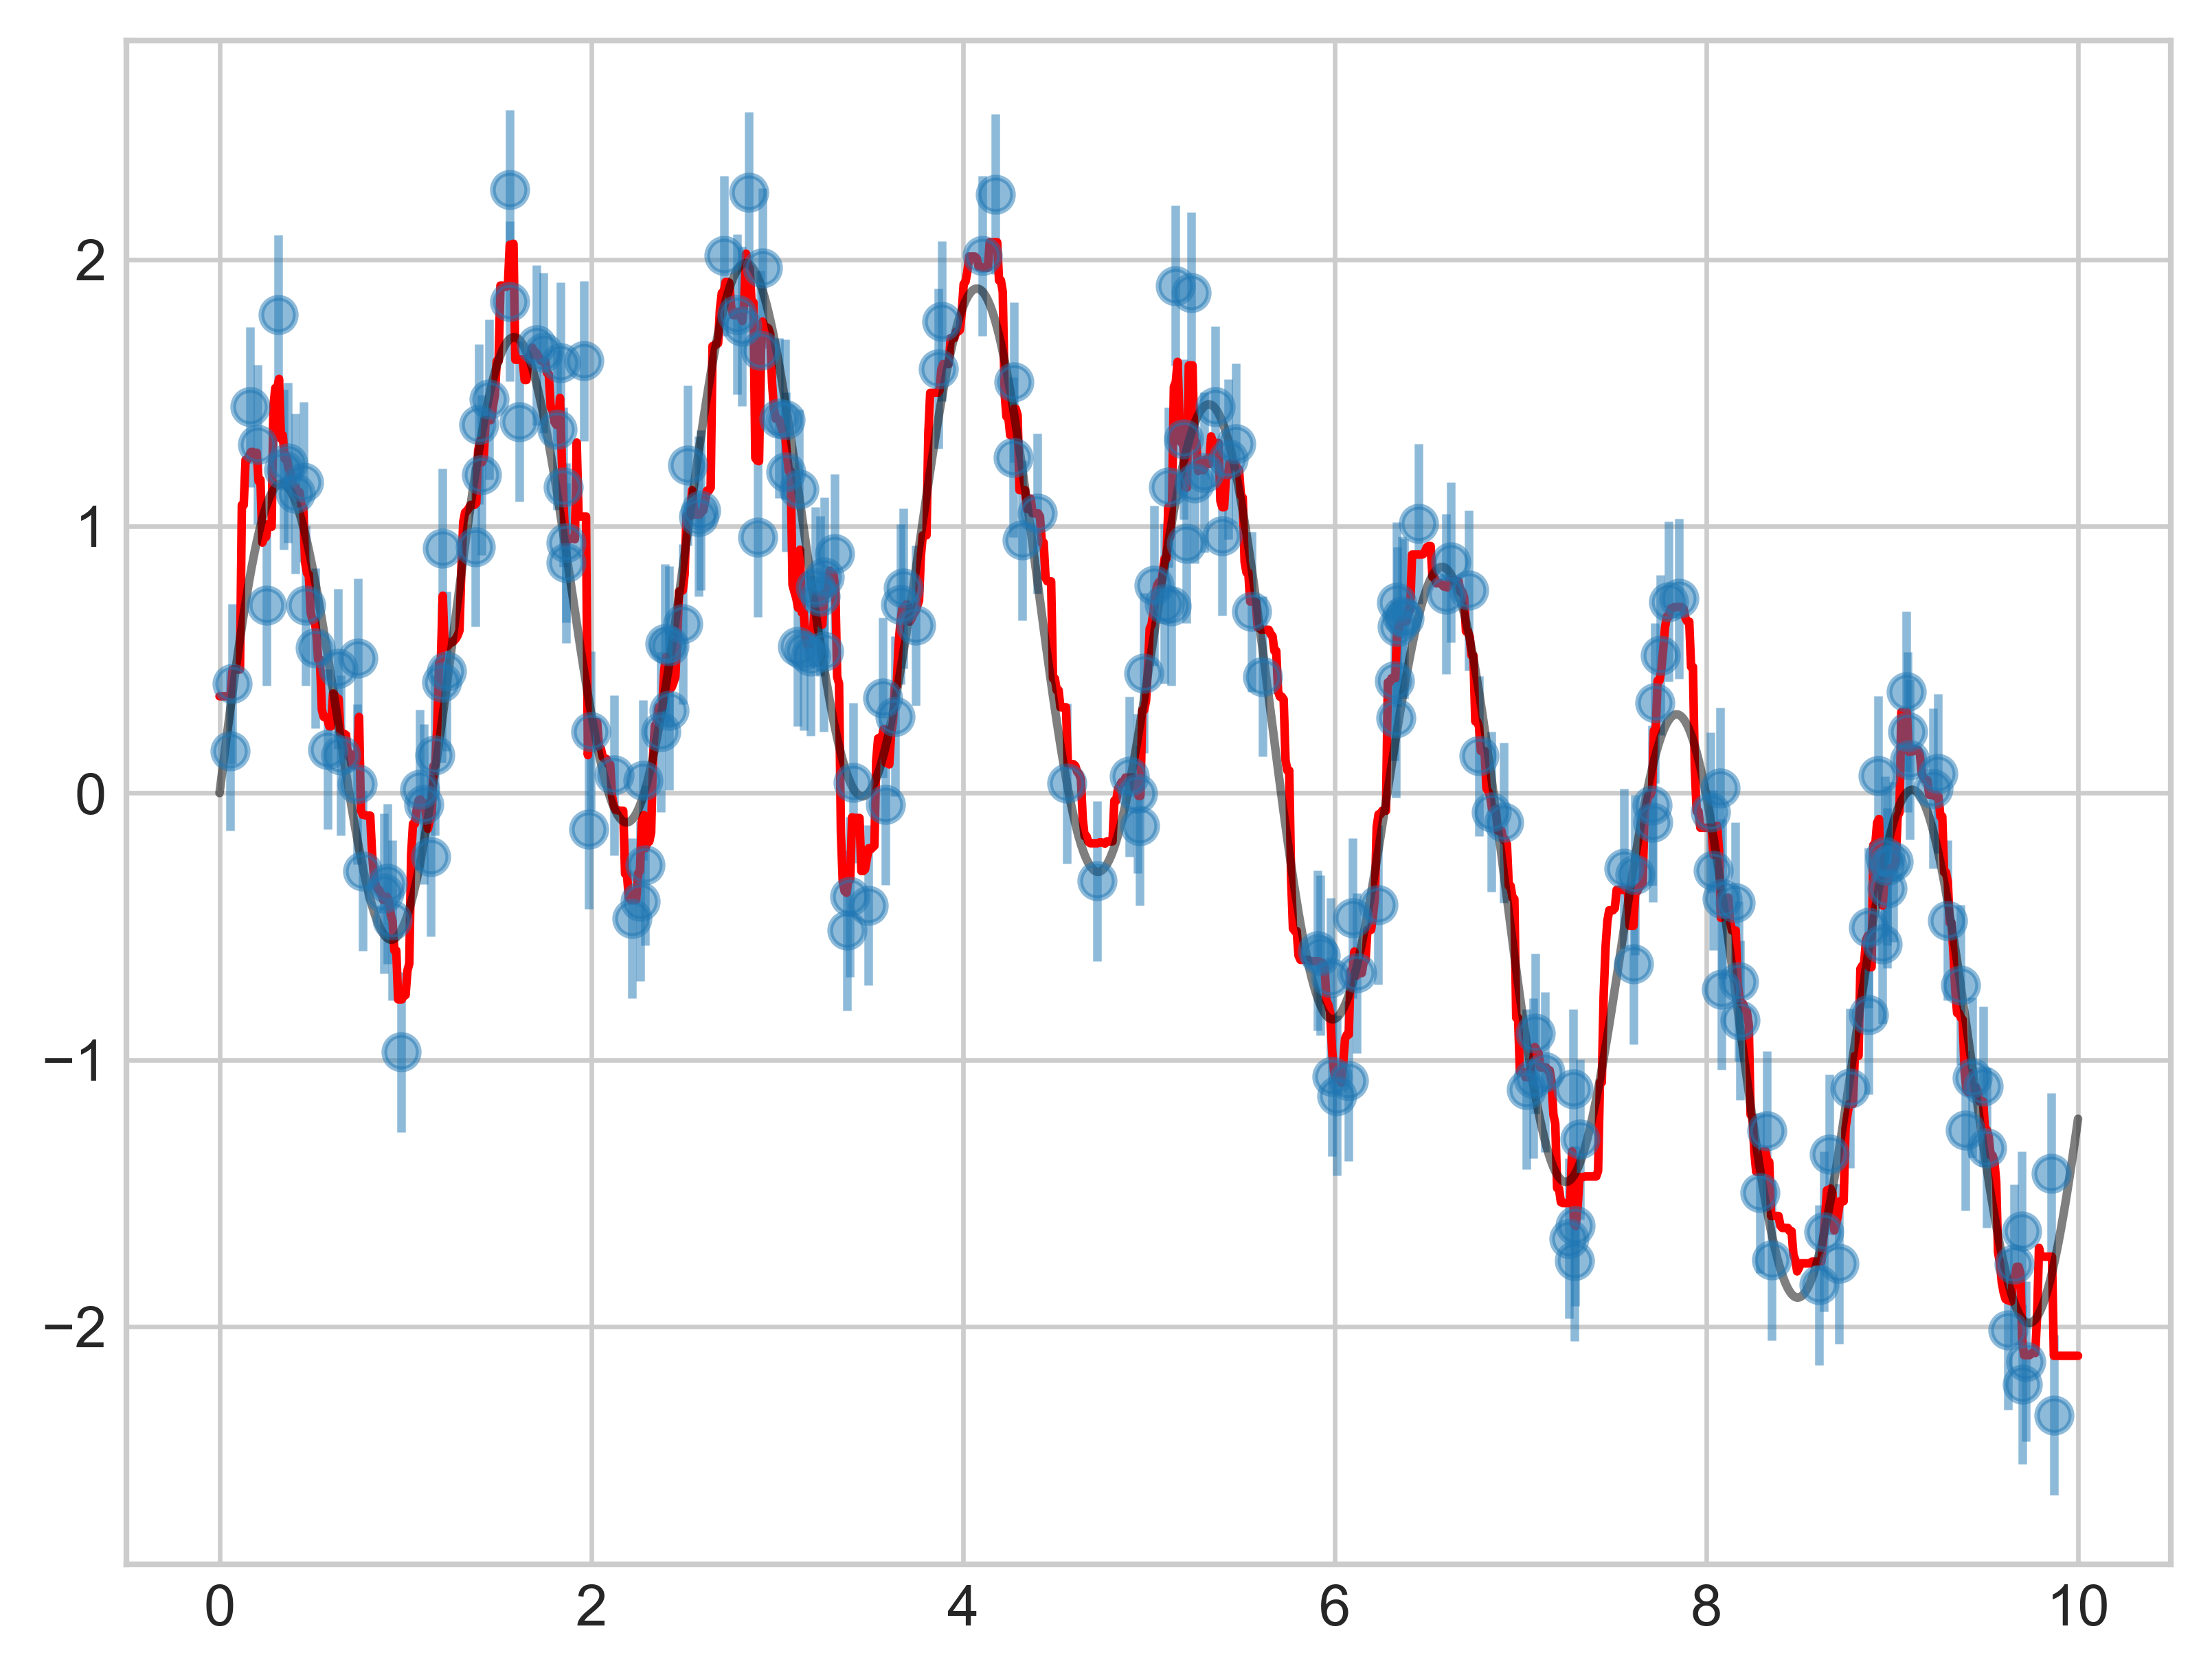

In [41]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor with 200 trees
forest = RandomForestRegressor(n_estimators=200)

# Fit the model to the data
forest.fit(x[:, None], y)

# Generate x values for prediction
xfit = np.linspace(0, 10, 1000)

# Predict y values using the trained model
yfit = forest.predict(xfit[:, None])

# Generate true y values using the model function
ytrue = model(xfit, sigma=0)

# Plot the data points with error bars, predicted values, and true values
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5, label='Data')
plt.plot(xfit, yfit, '-r', label='Random Forest Prediction')
plt.plot(xfit, ytrue, '-k', alpha=0.5, label='True Model')

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. The nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multi-period model!

### Example: Random Forest for Classifying Digits
In Chapter 38 we worked through an example using the digits dataset included with Scikit-Learn. Let's use that again here to see how the random forest classifier can be applied in this context:

In [42]:
# Import necessary libraries
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Print the keys of the dataset
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


To remind us what we're looking at, we'll visualize the first few data points (see the following figure):

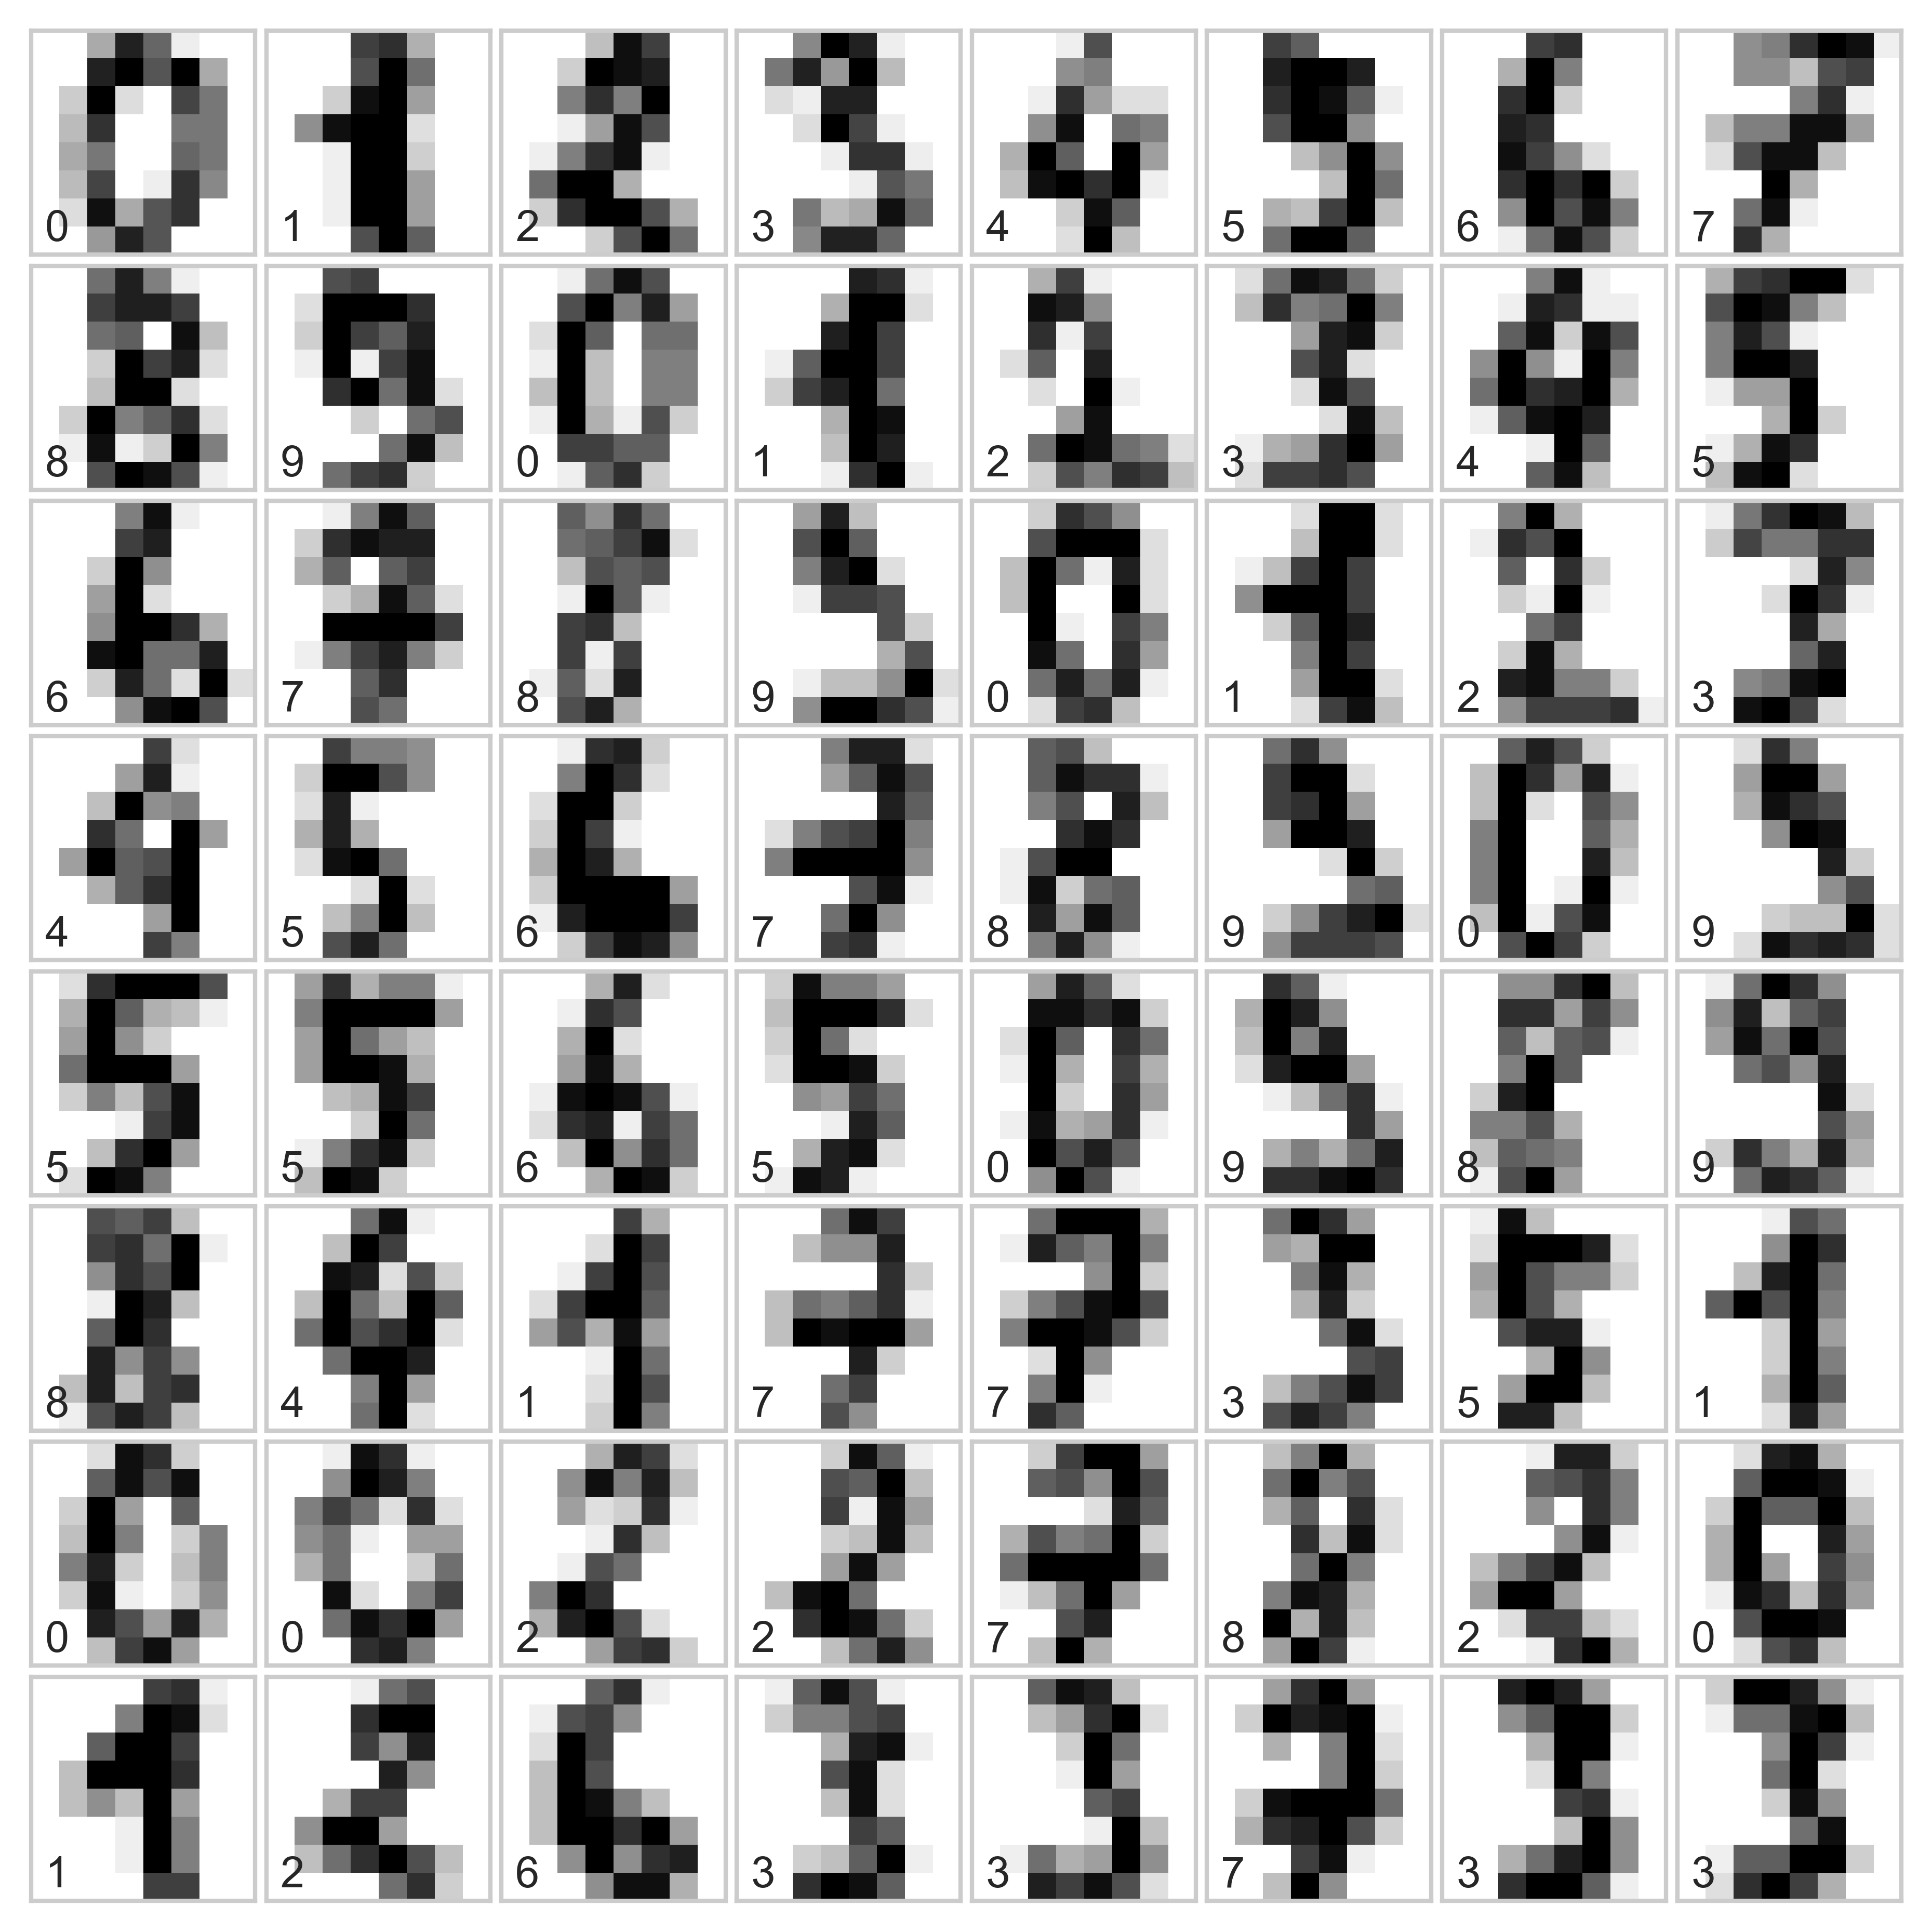

In [43]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can classify the digits using a random forest as follows:

In [44]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)

# Create a RandomForestClassifier model with 1000 estimators
model = RandomForestClassifier(n_estimators=1000)

# Train the model on the training data
model.fit(Xtrain, ytrain)

# Make predictions on the test data
ypred = model.predict(Xtest)

Let's look at the classification report for this classifier:

In [45]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix (see the following figure):

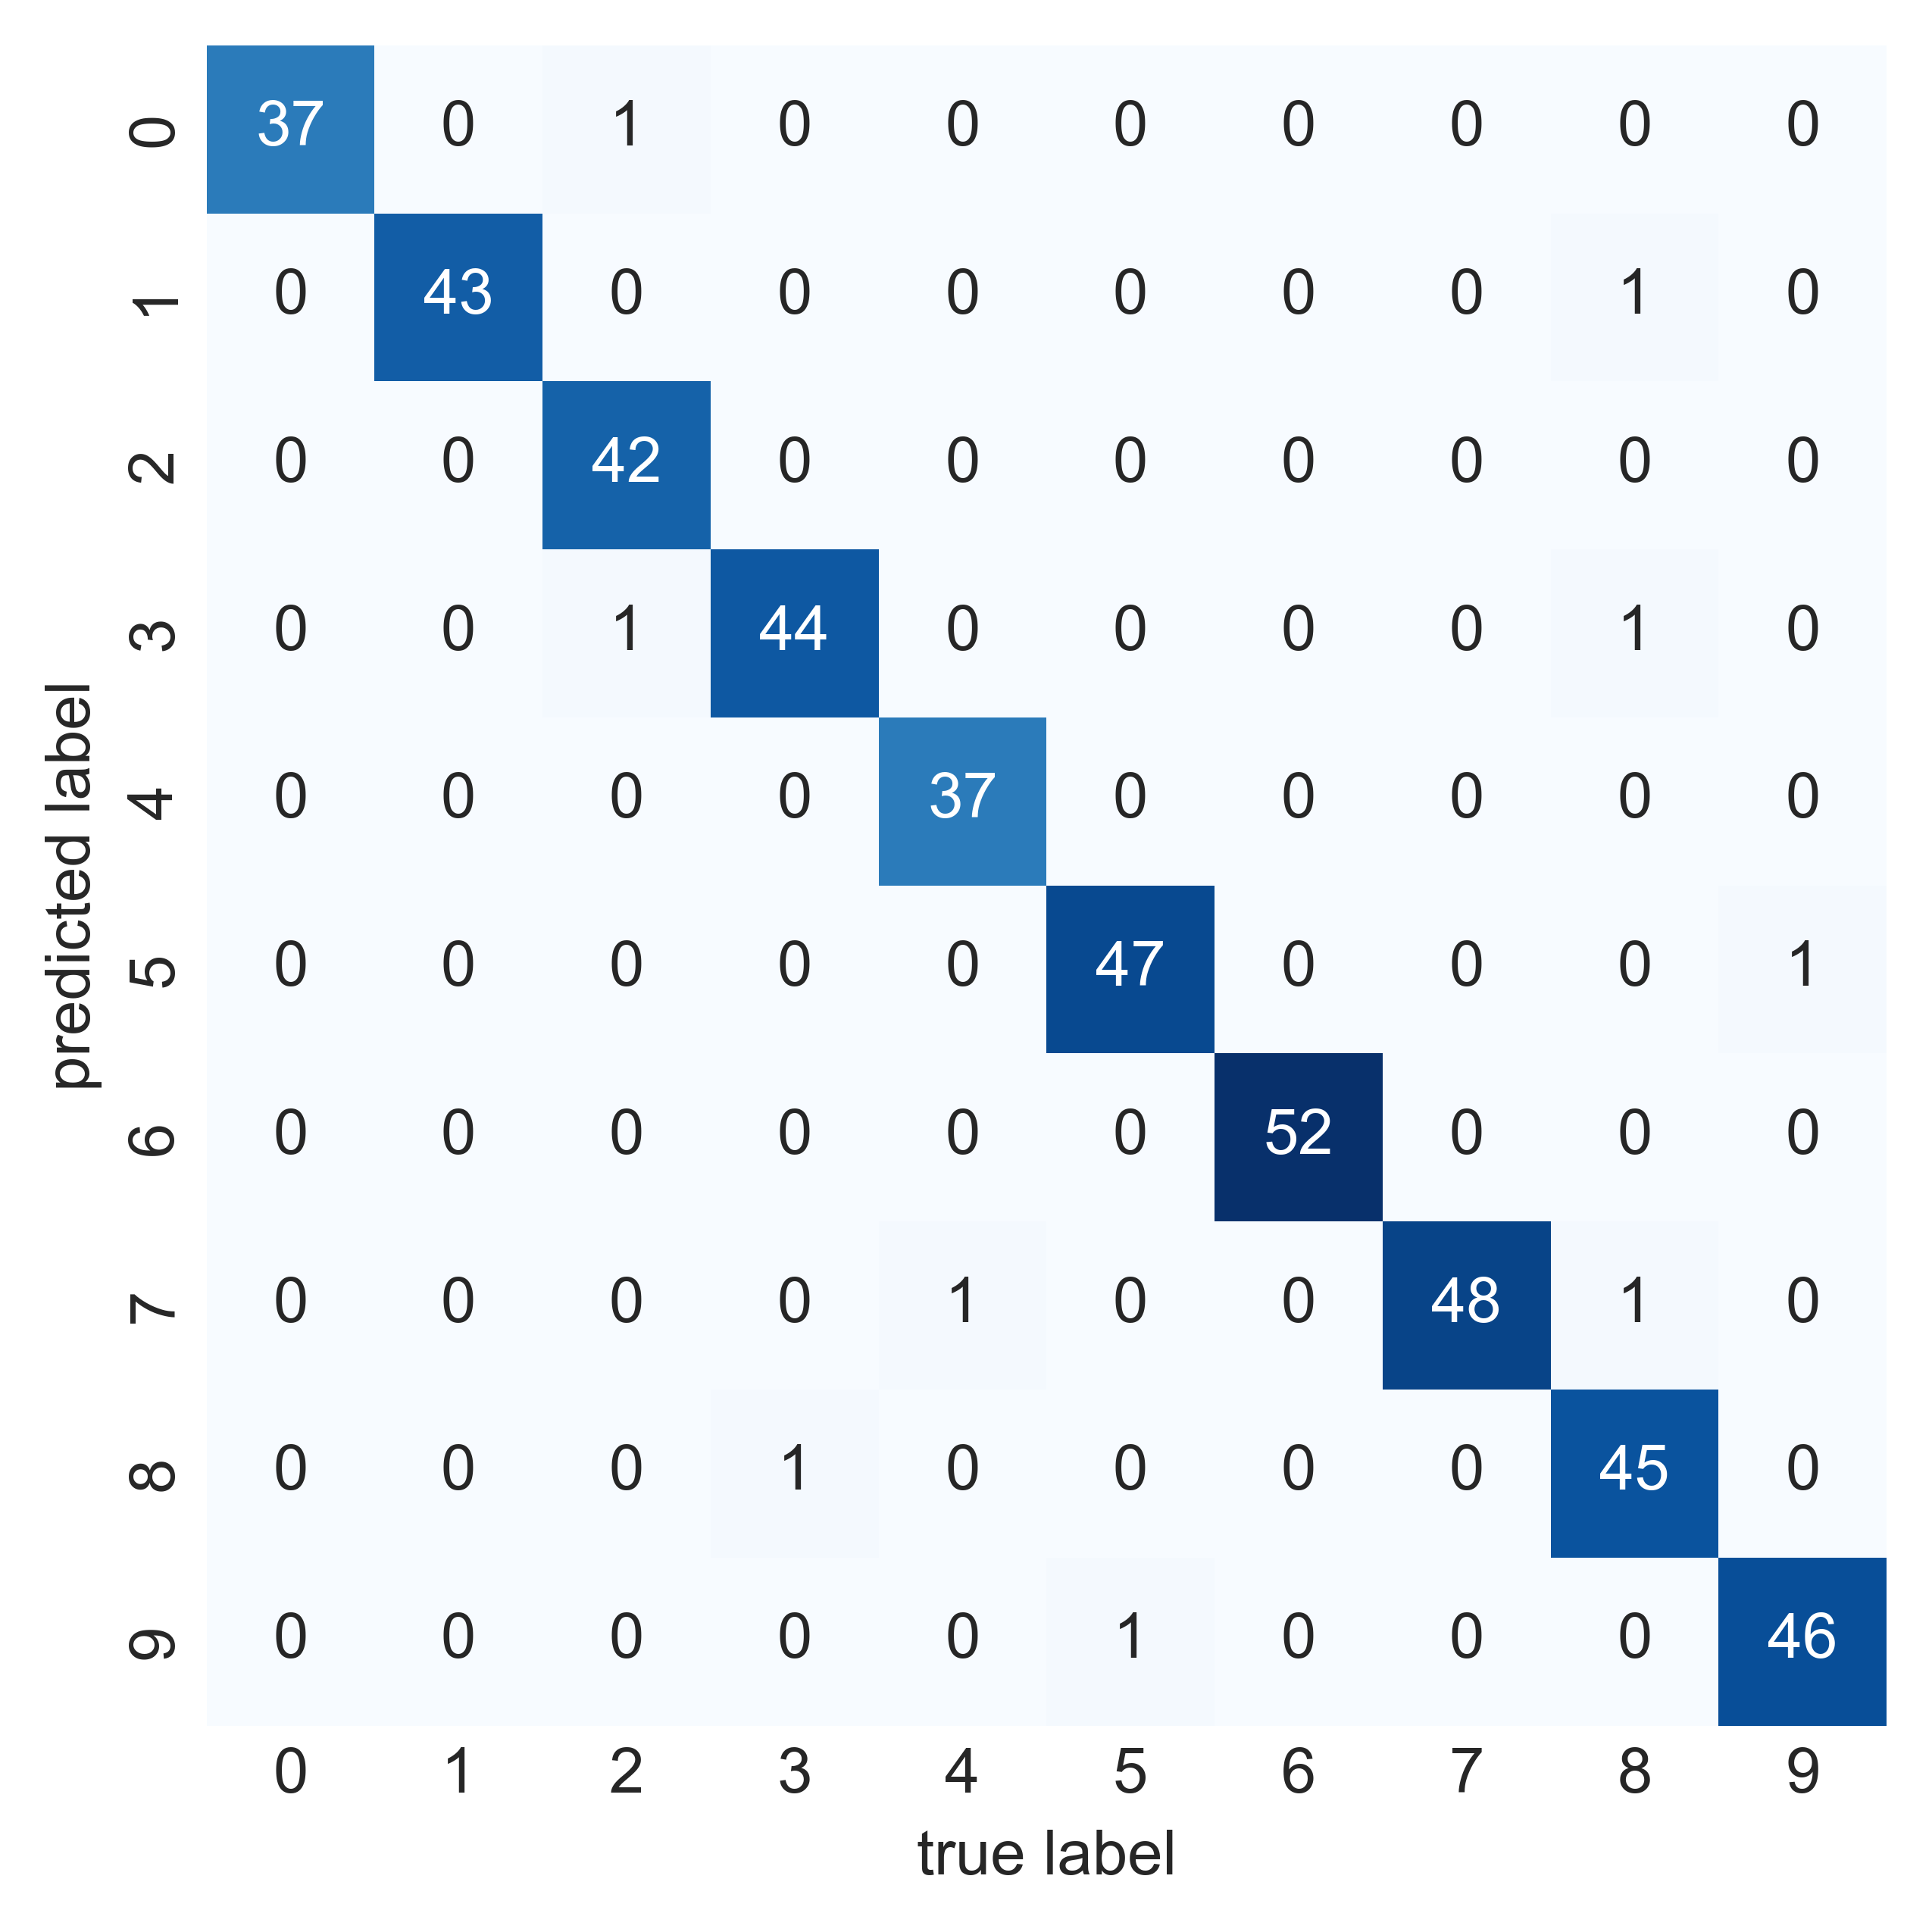

In [46]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
mat = confusion_matrix(ytest, ypred)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')

# Set axis labels
plt.xlabel('true label')
plt.ylabel('predicted label')

# Show the plot
plt.show()

We find that a simple, untuned random forest results in a quite accurate classification of the digits data.

### Summary
This chapter provided a brief introduction to the concept of ensemble estimators, and in particular the random forest, an ensemble of randomized decision trees. Random forests are a powerful method with several advantages:

Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba method).
The nonparametric model is extremely flexible and can thus perform well on tasks that are underfit by other estimators.
A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.